# Imports

In [ ]:
import tensorflow as tf
tf.__version__

!sudo pip3 install keras

In [ ]:
import os
import re
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json

# Reading the dataset

In [ ]:
meld_path = '/content/drive/MyDrive/ml-project/MELD.Raw'

In [ ]:
!ls drive/MyDrive/ml-project/MELD.Raw/face_train_splits

anger  disgust	fear  joy  neutral  sadness  surprise  undefined


In [ ]:
df = pd.read_csv(meld_path + '/train_sent_emo.csv')
df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


In [ ]:
def create_image_object(file):
    filename = file.split('/')[-1].split('.')[0]
    splitted = filename.split('_')
    dialogue = splitted[0]
    dialogue = [int(s) for s in re.findall(r'\d+', dialogue)][0]
    utterance = splitted[1]
    utterance = [int(s) for s in re.findall(r'\d+', utterance)][0]
    frame = splitted[2]
    frame = [int(s) for s in re.findall(r'\d+', frame)][0]
    face = splitted[2]
    face = [int(s) for s in re.findall(r'\d+', face)][0]
    img = cv2.imread(file)
    original_img = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    modified_img = np.array(img).reshape(48, 48, 1).astype('float32')
    modified_img2 = original_img
    emotion = df[(df['Dialogue_ID'] == dialogue) & 
                    (df['Utterance_ID'] == utterance)]['Emotion'].iloc[0]
    speaker = df[(df['Dialogue_ID'] == dialogue) & 
                    (df['Utterance_ID'] == utterance)]['Speaker'].iloc[0]

    return {
        'Dialogue_ID': dialogue, 'Utterance_ID': utterance, 
        'Frame_ID': frame, 
        'Face_ID': face, 'Speaker': speaker, 'Emotion': emotion, 
        'Image': modified_img, 'Image2': modified_img2
        }

images = []
# files.extend(glob.glob(meld_path + '/frame_train_splits'))

def traverse_dirs(folder):
    "Iterate through folder, storing files along the way"
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)

        if os.path.isfile(path):
            img_obj = create_image_object(path)
            images.append(img_obj)
        elif os.path.isdir(path):
            traverse_dirs(path)
            print('Done with {}'.format(path))

traverse_dirs(meld_path + '/face_train_splits2/')
df_images = pd.DataFrame(images)
df_images

Done with /content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits2/face_train_splits/neutral
Done with /content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits2/face_train_splits/surprise
Done with /content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits2/face_train_splits/fear
Done with /content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits2/face_train_splits/sadness
Done with /content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits2/face_train_splits/joy
Done with /content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits2/face_train_splits/disgust
Done with /content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits2/face_train_splits/anger
Done with /content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits2/face_train_splits/undefined
Done with /content/drive/MyDrive/ml-project/MELD.Raw/face_train_splits2/face_train_splits


,Dialogue_ID,Utterance_ID,Frame_ID,Face_ID,Speaker,Emotion,Image,Image2
0,151,15,1,1,Ross,neutral,"[[[2.0], [3.0], [4.0], [5.0], [12.0], [19.0], ...","[[[2, 2, 2], [3, 3, 3], [4, 4, 4], [5, 5, 5], ..."
1,151,17,1,1,Ross,neutral,"[[[15.0], [11.0], [14.0], [10.0], [11.0], [14....","[[[15, 15, 15], [11, 11, 11], [14, 14, 14], [1..."
2,163,0,1,1,Joey,neutral,"[[[33.0], [8.0], [3.0], [2.0], [5.0], [18.0], ...","[[[33, 33, 33], [8, 8, 8], [3, 3, 3], [2, 2, 2..."
3,163,10,1,1,Joey,neutral,"[[[2.0], [2.0], [2.0], [2.0], [3.0], [5.0], [7...","[[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ..."
4,169,2,1,1,Ross,neutral,"[[[14.0], [13.0], [9.0], [5.0], [4.0], [4.0], ...","[[[14, 14, 14], [13, 13, 13], [9, 9, 9], [5, 5..."
...,...,...,...,...,...,...,...,...
4881,651,10,1,1,Monica,anger,"[[[5.0], [3.0], [1.0], [0.0], [1.0], [3.0], [4...","[[[5, 5, 5], [3, 3, 3], [1, 1, 1], [0, 0, 0], ..."
4882,658,11,1,1,Phoebe,anger,"[[[173.0], [179.0], [166.0], [138.0], [116.0],...","[[[173, 173, 173], [179, 179, 179], [166, 166,..."
4883,670,1,1,1,Rachel,anger,"[[[153.0], [140.0], [139.0], [138.0], [134.0],...","[[[153, 153, 153], [140, 140, 140], [139, 139,..."
4884,761,0,1,1,Monica,anger,"[[[12.0], [10.0], [8.0], [6.0], [7.0], [9.0], ...","[[[12, 12, 12], [10, 10, 10], [8, 8, 8], [6, 6..."


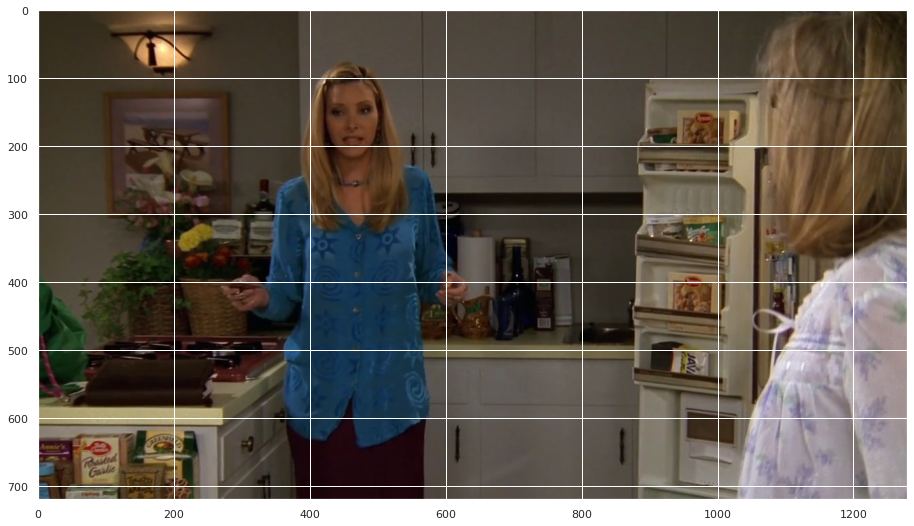

In [ ]:
def get_frame(sec, vid_cap, count, filename):
    # since we are only selecting the middle frame now
    if count != 3:
      return True
    vid_cap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    has_frames, image = vid_cap.read()
    if has_frames:
        return image
    return None

video_file = meld_path + '/train_splits/dia530_utt2.mp4'
frames_req = 5

filename, ext = os.path.splitext(video_file)
vid_cap = cv2.VideoCapture(video_file)

frame_count = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = vid_cap.get(cv2.CAP_PROP_FPS) 
filename = filename.split('/')[-1]

sec = 0
frame_rate = frame_count / (frames_req * fps)
count = 1

frame = get_frame(sec, vid_cap, count, filename)
retval = None

while count < frames_req:
    count = count + 1
    sec = sec + frame_rate
    sec = round(sec, 2)
    if count > frames_req:
        break
    frame = get_frame(sec, vid_cap, count, filename)
    if count == 3:
        retval = frame

fig = plt.figure(figsize=(16, 9))
plt.imshow(cv2.cvtColor(retval, cv2.COLOR_BGR2RGB))
plt.show()

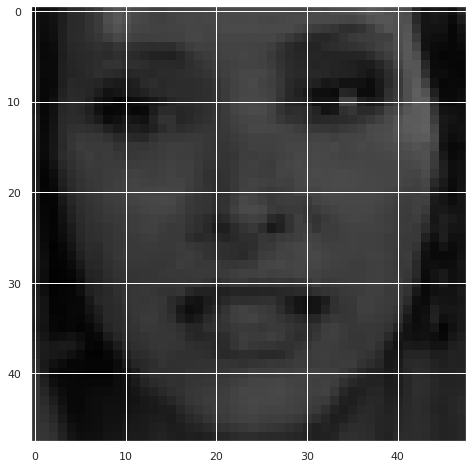

In [ ]:
fig = plt.figure(figsize=(8, 8))
image = cv2.imread(meld_path + '/face_train_splits/neutral/dia530_utt2_fr3_fa1.jpg')
plt.imshow(image)
plt.show()

In [ ]:
df_images[(df_images['Dialogue_ID'] == 530) & (df_images['Utterance_ID'] == 2)]

,Dialogue_ID,Utterance_ID,Frame_ID,Face_ID,Speaker,Emotion,Image,Image2
205,530,2,1,1,Phoebe,neutral,"[[[21.0], [15.0], [19.0], [30.0], [43.0], [44....","[[[21, 21, 21], [15, 15, 15], [19, 19, 19], [3..."


In [ ]:
df_images.groupby(['Dialogue_ID', 'Utterance_ID']).size()

Dialogue_ID  Utterance_ID
0            0               1
             1               1
             2               1
             3               1
             4               1
                            ..
1038         5               1
             8               1
             10              1
             11              1
             13              1
Length: 4856, dtype: int64

In [ ]:
len(df_images)

4886

In [ ]:
print('Unique Dialogue_ID:', len(df_images['Dialogue_ID'].unique()))
print('Unique Utterance_ID:', len(df_images['Utterance_ID'].unique()))
print('Unique (Dialogue_ID, Utterance_ID):', len(df_images.groupby(['Dialogue_ID', 'Utterance_ID']).size()))
print('Value counts for faces:\n{}'.format(df_images['Face_ID'].value_counts()))

Unique Dialogue_ID: 919
Unique Utterance_ID: 24
Unique (Dialogue_ID, Utterance_ID): 4856
Value counts for faces:
1    4856
2      29
3       1
Name: Face_ID, dtype: int64


In [ ]:
df_images.describe()

,Dialogue_ID,Utterance_ID,Frame_ID,Face_ID
count,4886.000000,4886.000000,4886.000000,4886.000000
mean,528.751535,6.521081,1.006345,1.006345
std,302.773805,4.935559,0.081946,0.081946
min,0.000000,0.000000,1.000000,1.000000
25%,256.000000,2.000000,1.000000,1.000000
50%,532.000000,6.000000,1.000000,1.000000
75%,803.000000,10.000000,1.000000,1.000000
max,1038.000000,23.000000,3.000000,3.000000


In [ ]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4886 entries, 0 to 4885
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Dialogue_ID   4886 non-null   int64 
 1   Utterance_ID  4886 non-null   int64 
 2   Frame_ID      4886 non-null   int64 
 3   Face_ID       4886 non-null   int64 
 4   Speaker       4886 non-null   object
 5   Emotion       4886 non-null   object
 6   Image         4886 non-null   object
 7   Image2        4886 non-null   object
dtypes: int64(4), object(4)
memory usage: 305.5+ KB


In [ ]:
# TODO - Now we can perform transform learning using a vgg16 model

# TODO (Update: Done) - Since we are getting a lot of faces per frame, 
# maybe creating a different model which will identify one of the main speakers 
# will reduce the number of rows as well as make the emotion analysis efficient

unique_emotions = df['Emotion'].unique()
for emo in unique_emotions:
    print("{}".format(emo))

neutral
surprise
fear
sadness
joy
disgust
anger


Creating an encoding for emotion

In [ ]:
emotion_encoding = {
  0: 'anger',
  1: 'disgust',
  2: 'fear',
  3: 'joy',
  4: 'neutral',
  5: 'sadness',
  6: 'surprise'
}

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
img_labels = le.fit_transform(df_images['Emotion'])
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [ ]:
df_images['Image'][0].shape

(48, 48, 1)

Let's split the data into train/validation sets

# Approach #1

In [ ]:
img_array = df_images['Image']
img_array = np.stack(img_array, axis=0)
img_array.shape

(23889, 48, 48, 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True, 
  stratify=img_labels,
  test_size=0.1, 
  random_state=42
)

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
import tensorflow as tf
tf.__version__

!sudo pip3 install keras

In [ ]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [ ]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
MODEL_DIR = meld_path + '/face_emotion_detection_model'

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

MC = ModelCheckpoint(MODEL_DIR + '/model_e_{epoch:02d}.hdf5',
                     save_best_only=True,
                     save_weights_only=True)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.

epochs = 50

optims = [
  optimizers.Adam(0.001),
]

In [ ]:
model = build_net(optims[0]) 

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

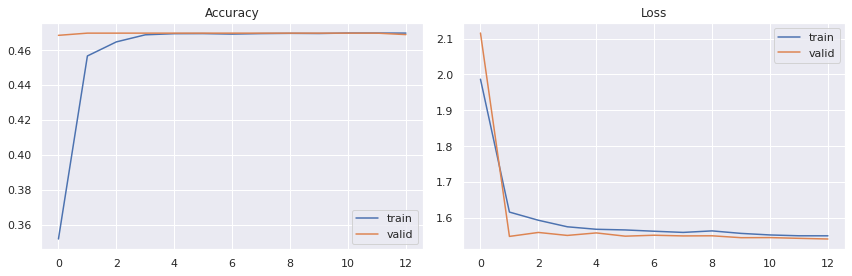

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig(MODEL_DIR + '/epoch_history_dcnn.png')
pyplot.show()

# Approach 2

In [ ]:
def build_advanced_net(model_weights=None, image_size: int = 48, classes: int = 7) -> Sequential:

    conv_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=(image_size, image_size, 3))
    for layer in conv_base.layers[:-2]:
        layer.trainable = False
    model = Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    if model_weights is not None:
        print('Extracting models from path!')
        model.load_weights(model_weights)

    return model

In [ ]:
# parameters
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARN_RATE = 0.001
TEST_RATIO = 0.1
SEED = 88
NUM_CLASSES = 7
IMG_DIR = meld_path + '/face_train_splits'
MODEL_DIR = meld_path + '/face_detection_model'

In [ ]:
img_array = df_images['Image2']
img_array = np.stack(img_array, axis=0)
img_array.shape

X_train, X_valid, y_train, y_valid = train_test_split(
    img_array, img_labels, 
    test_size=TEST_RATIO, 
    random_state=SEED
)

In [ ]:
# augment images using image data generator
aug = ImageDataGenerator(rotation_range=0.2,
                         shear_range=0.15)

In [ ]:
model = build_advanced_net()
model.summary()
optimizer = Adam(learning_rate=LEARN_RATE)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print('[INFO] model compiled.')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_37 (Dense)            (None, 512)               262656    
                                                                 
 dense_38 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 64)                16448     
                                                      

In [ ]:
# train model
ES = EarlyStopping(monitor='val_loss',
                   patience=2)
MC = ModelCheckpoint(MODEL_DIR + '/model_e_{epoch:02d}.h5',
                     save_best_only=True,
                     save_weights_only=False)
print('[INFO] starting training...')

H = model.fit(aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
              epochs=NUM_EPOCHS,
              validation_data=aug.flow(X_valid, y_valid, batch_size=BATCH_SIZE),
              callbacks=[ES, MC],
              verbose=1)
print('[INFO] model trained.')

[INFO] starting training...
Epoch 1/50
69/69 [==============================] - 35s 495ms/step - loss: 1.8554 - accuracy: 0.3600 - val_loss: 1.9618 - val_accuracy: 0.4315
Epoch 2/50
69/69 [==============================] - 34s 492ms/step - loss: 1.6467 - accuracy: 0.4678 - val_loss: 1.7807 - val_accuracy: 0.4315
Epoch 3/50
69/69 [==============================] - 33s 484ms/step - loss: 1.5912 - accuracy: 0.4701 - val_loss: 1.7162 - val_accuracy: 0.4315
Epoch 4/50
69/69 [==============================] - 34s 492ms/step - loss: 1.5744 - accuracy: 0.4724 - val_loss: 1.6925 - val_accuracy: 0.4315
Epoch 5/50
69/69 [==============================] - 34s 487ms/step - loss: 1.5708 - accuracy: 0.4724 - val_loss: 1.6854 - val_accuracy: 0.4315
Epoch 6/50
69/69 [==============================] - 34s 488ms/step - loss: 1.5625 - accuracy: 0.4726 - val_loss: 1.6121 - val_accuracy: 0.4315
Epoch 7/50
69/69 [==============================] - 32s 471ms/step - loss: 1.5567 - accuracy: 0.4726 - val_loss: 1

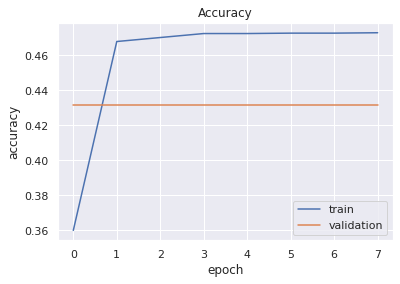

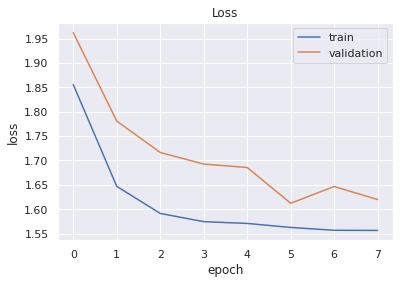

In [ ]:
# plot loss and accuracy history
plt.figure()
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig(MODEL_DIR + '/model_accuracy.png')
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig(MODEL_DIR + '/model_loss.png')

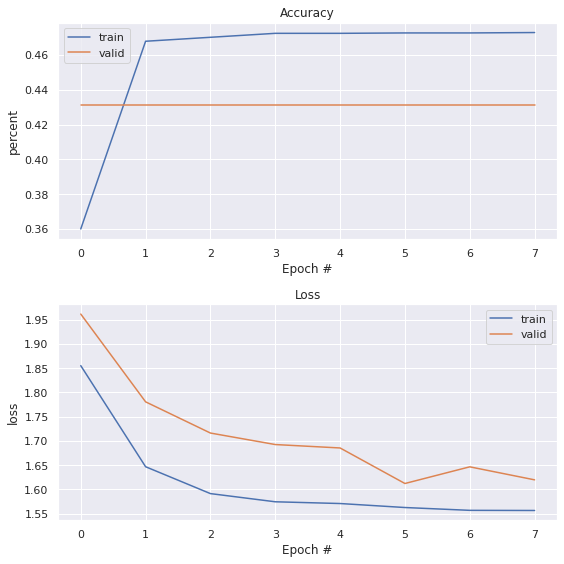

In [ ]:
import seaborn as sns

history = H

sns.set()
fig = plt.figure(2, (8, 8))

ax = plt.subplot(2, 1, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('percent')
plt.tight_layout()

ax = plt.subplot(2, 1, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.xlabel('Epoch #')
plt.ylabel('loss')
plt.tight_layout()
plt.show()